In [1]:
# TODO drop Kherson point
# TODO investigate Unnamed

In [2]:
import pandas as pd
import seaborn as sns

In [3]:
SEED = 14

In [4]:
data = pd.read_parquet("cleaned_data/data.parquet")
print(data.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6010 entries, 0 to 6010
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   hotspot_id              6010 non-null   int64         
 1   blacklist_score         6010 non-null   float64       
 2   static_score            6010 non-null   float64       
 3   dynamic_score           6010 non-null   float64       
 4   connection_stats_score  6010 non-null   float64       
 5   last_conn_date          6010 non-null   datetime64[ns]
 6   last_seen_date          6010 non-null   datetime64[ns]
 7   num_conn                6010 non-null   int64         
 8   unique_conn             6010 non-null   int64         
 9   percent_available       6010 non-null   float64       
 10  percent_protected       6010 non-null   float64       
 11  enabled_moderator       6010 non-null   bool          
dtypes: bool(1), datetime64[ns](2), float64(6), int64

## Analysis

In [5]:
data

hotspot_id  blacklist_score  static_score  dynamic_score  \
0       14650480              0.0          0.22           0.45   
1       14110275              0.0          0.22           0.00   
2       16012785              0.0          0.18           0.16   
3       14863945              0.0          0.22           0.05   
4        9295867              0.0          0.39           0.00   
...          ...              ...           ...            ...   
6006    13213372              0.0          0.25           0.00   
6007     5504114              0.0          0.22           0.00   
6008    15109612              0.0          0.48           0.00   
6009      502326              0.0          0.12           0.00   
6010    14242378              0.0          0.22           0.00   

      connection_stats_score last_conn_date last_seen_date  num_conn  \
0                       0.69     2022-08-21     2021-05-01         5   
1                       0.67     2022-02-04     2022-02-04         4   
2                       0.67     2022-02-05     2022-02-15         4   
3                       0.72     2022-03-15     2021-06-12         6   
4                       0.52     2017-12-07     2017-12-07         1   
...                      ...            ...            ...       ...   
6006                    0.52     2020-04-27     2020-04-27         1   
6007                    0.52     2016-04-10     2022-01-02         1   
6008                    0.52     2021-07-20     2021-07-20         1   
6009                    0.52     2013-11-19     2013-11-19         1   
6010                    0.52     2021-01-29     2021-01-29         1   

      unique_conn  percent_available  percent_protected  enabled_moderator  
0               2                1.0                1.0               True  
1               2                1.0                1.0               True  
2               2                1.0                1.0               True  
3               2                1.0                0.8               True  
4               1                1.0                0.0               True  
...           ...                ...                ...                ...  
6006            1                1.0                0.0               True  
6007            1                1.0                0.0               True  
6008            1                1.0                0.0               True  
6009            1                1.0                0.0               True  
6010            1                1.0                0.0               True  

[6010 rows x 12 columns]

In [7]:
data.nunique()



hotspot_id                6003
blacklist_score              2
static_score                79
dynamic_score               90
connection_stats_score      22
last_conn_date            2243
last_seen_date            2059
num_conn                   615
unique_conn                 57
percent_available            2
percent_protected           57
enabled_moderator            1
dtype: int64

In [8]:
# small_variaty_columns = hotspots_nunique[hotspots_nunique < 50].index

# for column in small_variaty_columns:
#     print(column)
#     print(hotspots[column].value_counts(dropna = False))
#     print()

### Features Analysis

In [9]:
SORTED_QUALITY = ["spam", "bad", "moderate", "good"]
def calculate_quality(scores):
    def calculate_quality_for_row(row):
        blacklist_score, dynamic_score = row["blacklist_score"], row["dynamic_score"]
        if blacklist_score == 1:
            return "spam"
        if dynamic_score < 0.3:
            return "bad"
        elif dynamic_score >= 0.3 and dynamic_score < 0.6:
            return "moderate"

        return "good"
    quality = scores.apply(calculate_quality_for_row, axis = 1)\
        .astype("category").cat.reorder_categories(SORTED_QUALITY)
    return quality

def calculate_quality_code(scores):
    quality = calculate_quality(scores)
    return quality.cat.codes.rename("quality_cat_id")

print(calculate_quality(data).value_counts())
print()


bad         3787
good        1177
moderate     949
spam          97
dtype: int64



In [10]:
scores = data.copy()

scores["quality_cat_id"] = calculate_quality_code(scores)
print()
print(scores["quality_cat_id"].value_counts())


1    3787
3    1177
2     949
0      97
Name: quality_cat_id, dtype: int64


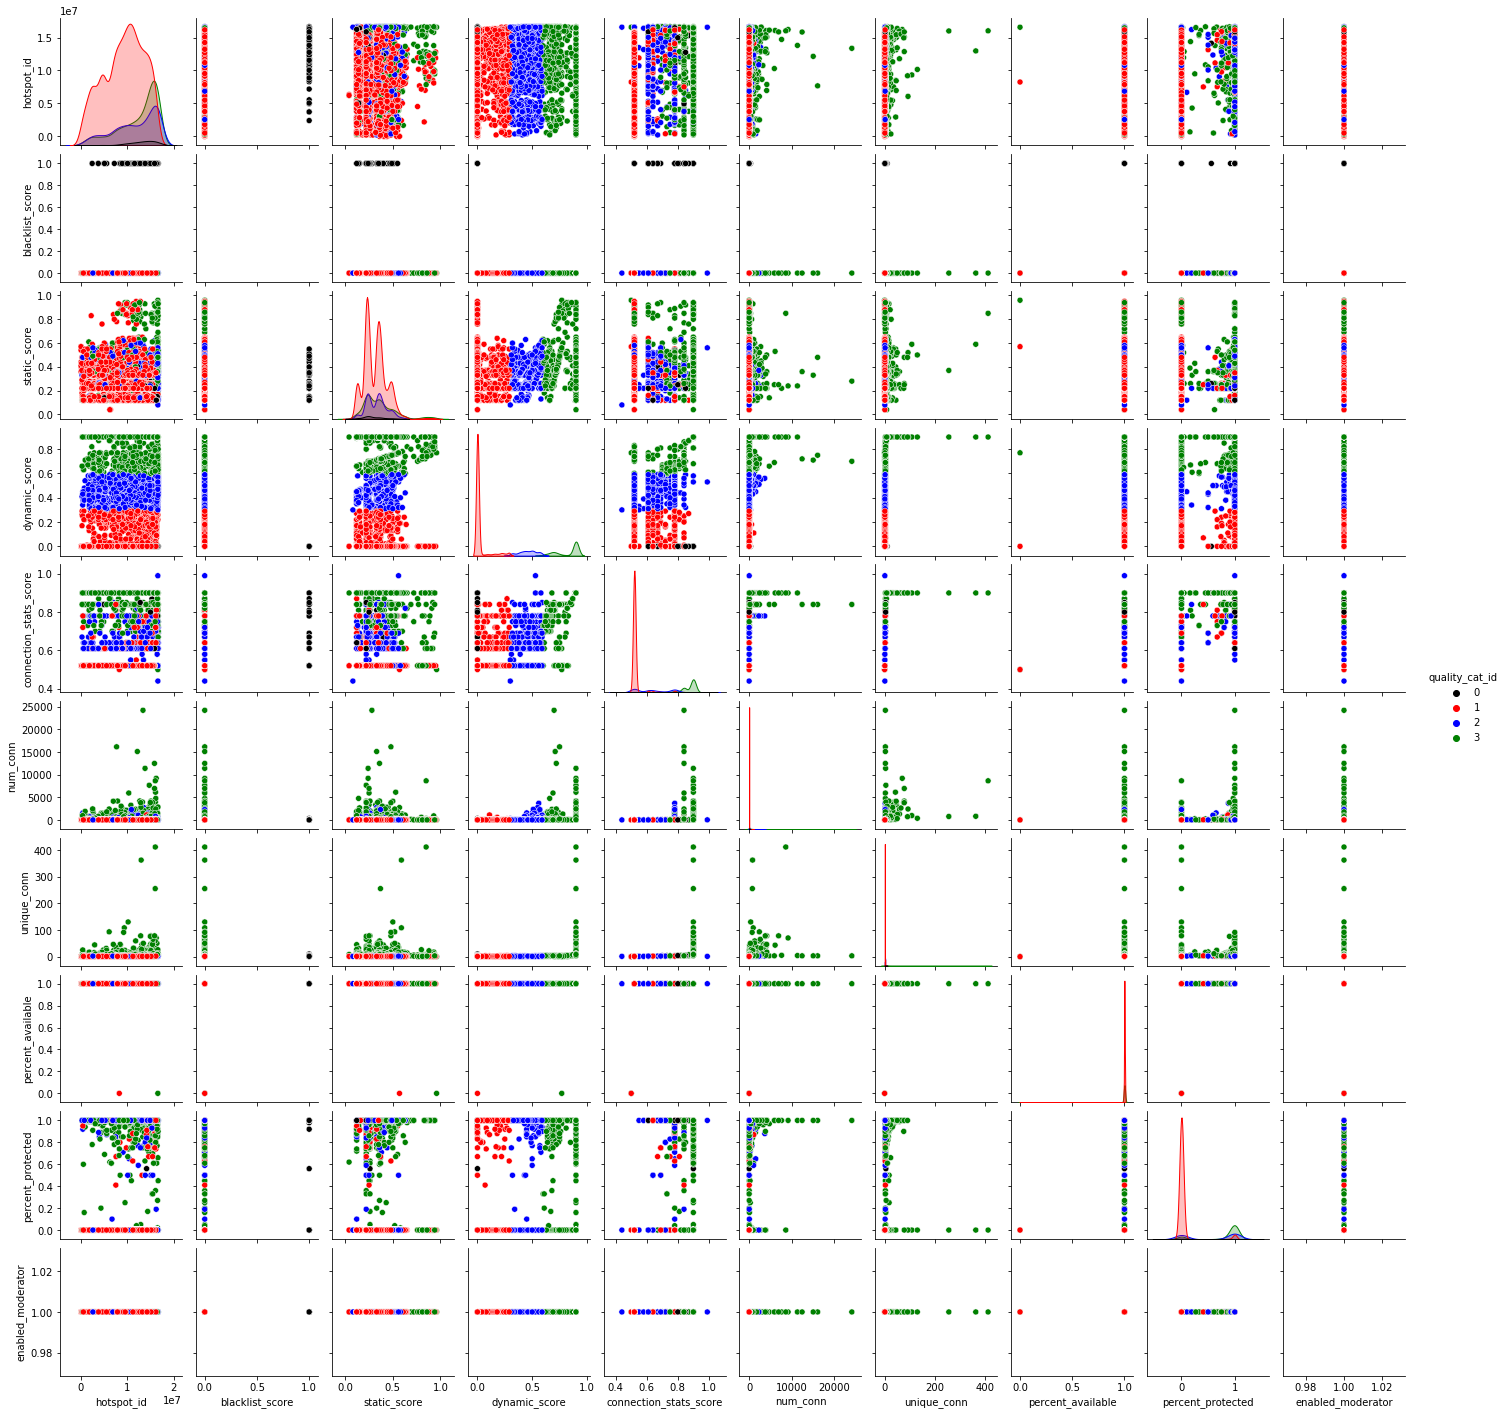

In [11]:
default_pairplot = sns.pairplot(scores, hue = "quality_cat_id", palette = {
    0: "black",
    1: "red",
    2: "blue",
    3: "green",
}, height = 2)
default_pairplot

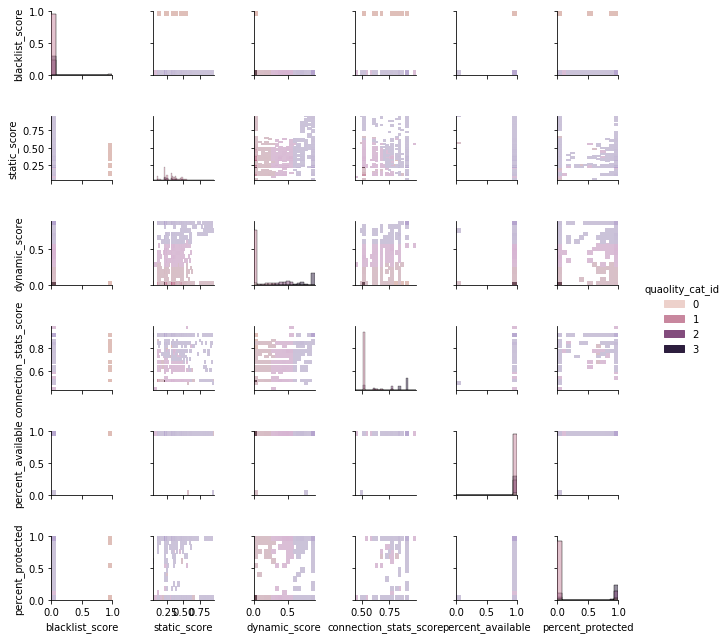

In [53]:
sns.pairplot(scores, hue = "quality_cat_id", kind="hist", height=1.5)


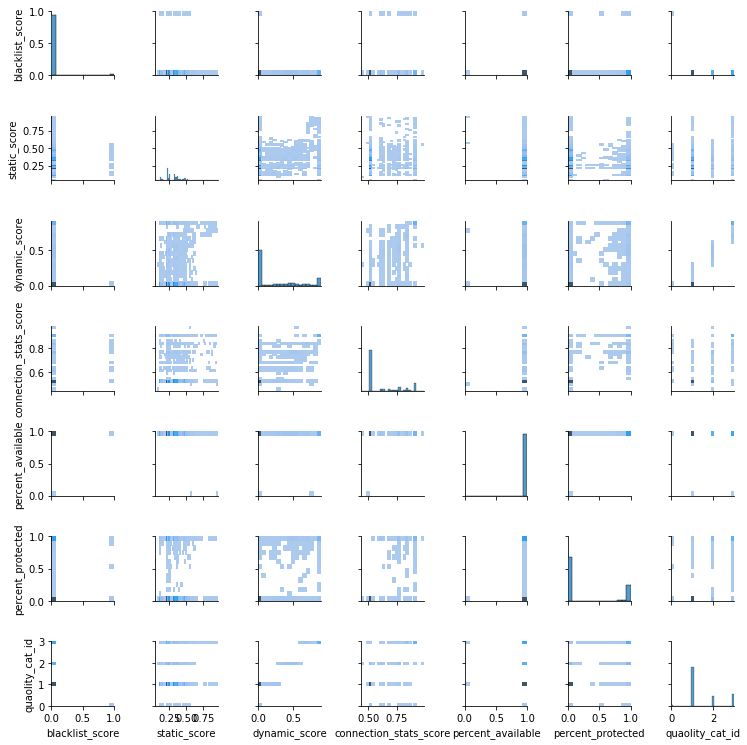

In [52]:
sns.pairplot(scores, kind="hist", height=1.5)


In [ ]:
sns.pairplot(scores, hue = "quality_cat_id", palette = {
    0: "black",
    1: "red",
    2: "blue",
    3: "green",
}, height=1.5)

## Model


In [12]:
import lightgbm as lgbm 


In [13]:
data

hotspot_id  blacklist_score  static_score  dynamic_score  \
0       14650480              0.0          0.22           0.45   
1       14110275              0.0          0.22           0.00   
2       16012785              0.0          0.18           0.16   
3       14863945              0.0          0.22           0.05   
4        9295867              0.0          0.39           0.00   
...          ...              ...           ...            ...   
6006    13213372              0.0          0.25           0.00   
6007     5504114              0.0          0.22           0.00   
6008    15109612              0.0          0.48           0.00   
6009      502326              0.0          0.12           0.00   
6010    14242378              0.0          0.22           0.00   

      connection_stats_score last_conn_date last_seen_date  num_conn  \
0                       0.69     2022-08-21     2021-05-01         5   
1                       0.67     2022-02-04     2022-02-04         4   
2                       0.67     2022-02-05     2022-02-15         4   
3                       0.72     2022-03-15     2021-06-12         6   
4                       0.52     2017-12-07     2017-12-07         1   
...                      ...            ...            ...       ...   
6006                    0.52     2020-04-27     2020-04-27         1   
6007                    0.52     2016-04-10     2022-01-02         1   
6008                    0.52     2021-07-20     2021-07-20         1   
6009                    0.52     2013-11-19     2013-11-19         1   
6010                    0.52     2021-01-29     2021-01-29         1   

      unique_conn  percent_available  percent_protected  enabled_moderator  
0               2                1.0                1.0               True  
1               2                1.0                1.0               True  
2               2                1.0                1.0               True  
3               2                1.0                0.8               True  
4               1                1.0                0.0               True  
...           ...                ...                ...                ...  
6006            1                1.0                0.0               True  
6007            1                1.0                0.0               True  
6008            1                1.0                0.0               True  
6009            1                1.0                0.0               True  
6010            1                1.0                0.0               True  

[6010 rows x 12 columns]

In [14]:
y = calculate_quality_code(data)
print(y.info())
print()

insight_columns = ["blacklist_score", "hotspot_id", "dynamic_score"]
X = data.drop(columns = insight_columns)
print(X.info())

<class 'pandas.core.series.Series'>
Int64Index: 6010 entries, 0 to 6010
Series name: quality_cat_id
Non-Null Count  Dtype
--------------  -----
6010 non-null   int8 
dtypes: int8(1)
memory usage: 181.9 KB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6010 entries, 0 to 6010
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   static_score            6010 non-null   float64       
 1   connection_stats_score  6010 non-null   float64       
 2   last_conn_date          6010 non-null   datetime64[ns]
 3   last_seen_date          6010 non-null   datetime64[ns]
 4   num_conn                6010 non-null   int64         
 5   unique_conn             6010 non-null   int64         
 6   percent_available       6010 non-null   float64       
 7   percent_protected       6010 non-null   float64       
 8   enabled_moderator       6010 non-null   bool          
dtypes: bool(1), dateti

In [16]:
# pd.concat([data.loc[y_train.index], y_train], axis = 1)

In [17]:
# X_y_pairplot = sns.pairplot(pd.concat([X, y], axis = 1), hue = y.name, palette = {
#     0: "black",
#     1: "red",
#     2: "blue",
#     3: "green",
# }, height = 2)
# X_y_pairplot

In [18]:
# X_y_pairplot_2 = sns.pairplot(pd.concat([X, y], axis = 1), height = 2)
# X_y_pairplot_2

In [19]:
import pandas as pd
import numpy as np
today = pd.Timestamp.now()

from lib import calculate_days_passed

X["last_conn_days"] = calculate_days_passed(X["last_conn_date"], today)
X["last_seen_days"] = calculate_days_passed(X["last_seen_date"], today)

X.drop(columns = ["last_conn_date", "last_seen_date"], inplace = True)

In [20]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6010 entries, 0 to 6010
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   static_score            6010 non-null   float64
 1   connection_stats_score  6010 non-null   float64
 2   num_conn                6010 non-null   int64  
 3   unique_conn             6010 non-null   int64  
 4   percent_available       6010 non-null   float64
 5   percent_protected       6010 non-null   float64
 6   enabled_moderator       6010 non-null   bool   
 7   last_conn_days          6010 non-null   int16  
 8   last_seen_days          6010 non-null   int16  
dtypes: bool(1), float64(4), int16(2), int64(2)
memory usage: 487.1 KB


In [21]:
# default_pairplot = sns.pairplot(scores, hue = "quality_cat_id", palette = {
#     0: "black",
#     1: "red",
#     2: "blue",
#     3: "green",
# }, height = 2)
# default_pairplot

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f98bdeb4820> (for post_execute):


KeyboardInterrupt: 

### Train

In [22]:
X_for_exp = X #.drop(columns = ["connection_stats_score", "percent_protected", "last_conn_days", "static_score"])
X_for_exp = X[["connection_stats_score", "last_seen_days", "last_conn_days"]]
y_for_exp = y.loc[X.index]

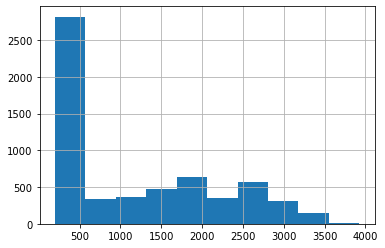

In [24]:
X_for_exp["last_seen_days"].hist()

In [25]:
from typing import List
import plotly.graph_objs as go
from sklearn.metrics import confusion_matrix

def confusion_matrix_plot(y_test: List[str], y_pred: List[str], labels: List[str], display_labels: List[str] = None, normalise: bool = False) -> go.Figure:
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=labels)

    # Normalize the matrix by rows
    if normalise:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Define the display labels
    if display_labels is None:
        display_labels = labels

    # Define the data for the heatmap
    data = go.Heatmap(
        z=cm,
        x=display_labels,
        y=display_labels,
        colorscale='YlGnBu'
    )

    # Define the layout of the plot
    layout = go.Layout(
        title='Confusion Matrix',
        xaxis=dict(title='Predicted label'),
        yaxis=dict(title='True label')
    )

    # Create the plot
    fig = go.Figure(data=[data], layout=layout)
    return fig



[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 529
[LightGBM] [Info] Number of data points in the train set: 4808, number of used features: 3
[LightGBM] [Info] Start training from score -4.096010
[LightGBM] [Info] Start training from score -0.461389
[LightGBM] [Info] Start training from score -1.838161
[LightGBM] [Info] Start training from score -1.640704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

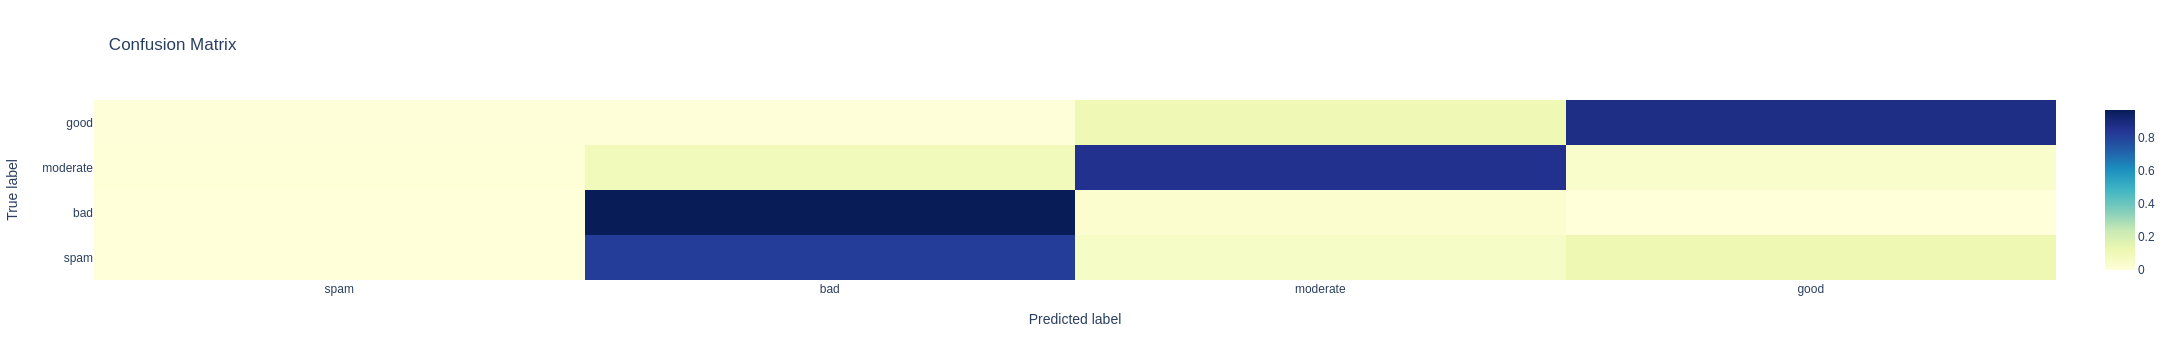

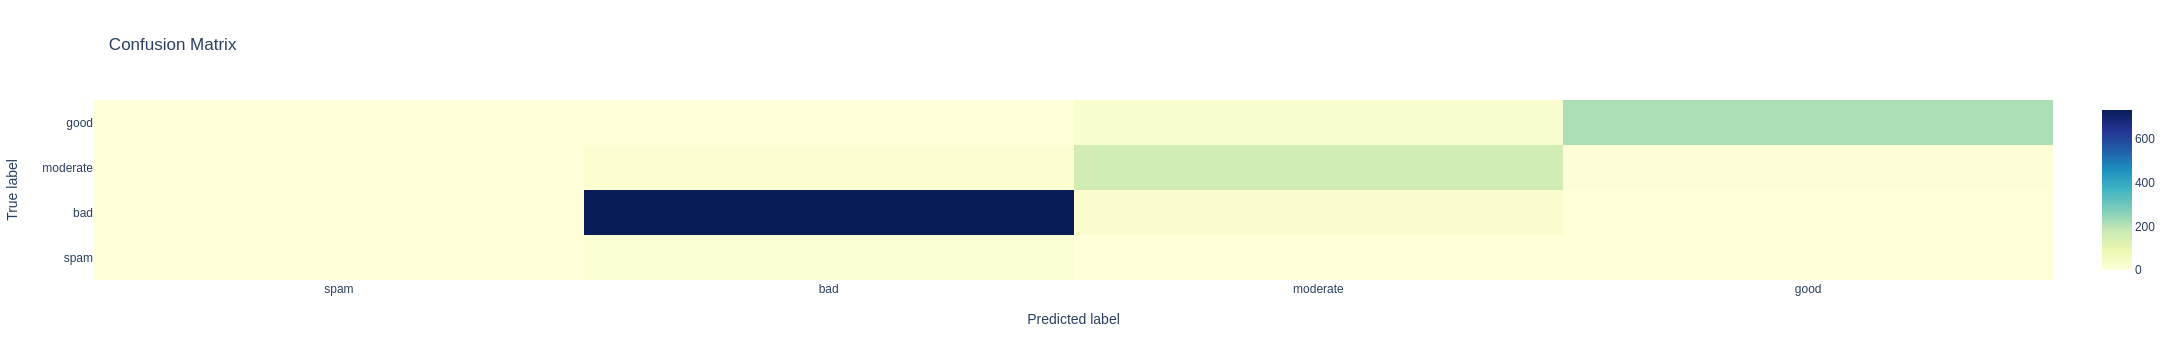

In [26]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load your data and split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_for_exp, y_for_exp, test_size=0.2, random_state=SEED)



# Create an instance of the LGBMClassifier
params = {
    'num_classes': 4,
    'objective': 'multiclass',
    'random_state': SEED,
    'n_estimators': 100,
    'max_depth': 10,
    'learning_rate': 0.1
}

lgbm = LGBMClassifier(**params)

# Fit the model on the training data
lgbm.fit(X_train, y_train)

# Predict the class labels of the testing data
y_pred = lgbm.predict(X_test)
print("Train classes: ")
print(y_train.value_counts())
print("Test classes: ")
print(y_test.value_counts())
print("Test predicts: ")
print( pd.DataFrame(y_pred).value_counts() )
# Print the classification report
print(classification_report(y_test, y_pred))

correlations = pd.concat([X_for_exp, y_for_exp], axis=1).corr()

# Print the correlation between each feature and the target variable
print("Correlation to quality")
print(correlations[y.name].iloc[:-1])

cm = confusion_matrix_plot(y_test, y_pred, lgbm.classes_, display_labels = SORTED_QUALITY, normalise = True)
cm.show()

cm = confusion_matrix_plot(y_test, y_pred, lgbm.classes_, display_labels = SORTED_QUALITY, normalise = False)
cm.show()

In [27]:
# Get feature importances and column names
importances = lgbm.feature_importances_
features = X_for_exp.columns

# Create a list of tuples of feature names and importances, sorted by importance
feature_importances = [(feature, importance) for feature, importance in zip(features, importances)]
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# Print the sorted list of features and their importances
for feature, importance in feature_importances:
    print('{}: {}'.format(feature, importance))

last_seen_days: 5287
last_conn_days: 5155
connection_stats_score: 1540


In [49]:
import pickle
# Save the model to a file using pickle
with open('lgbm_model.pkl', 'wb') as f:
    pickle.dump(lgbm, f)